In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import seaborn as sns
import plotly.express as px
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Read Data

In [7]:
# make directories
if not os.path.isdir('pipeline'):
    os.system('mkdir -p pipeline')
else:
    print("pipeline directory already exists - delete or rename it")

In [8]:
json_labels = {}

total_length = 0
nfiles = 5
i=0

raw_dir = './data'

os.system('mkdir pipeline/1_xyz')

for subdir in os.listdir(raw_dir):
    if os.path.exists(f'{raw_dir}/{subdir}/{subdir}_data.json'):
        # json files with annotations exists - dataset is annotated
        i += 1

        # Read labels
        with open(f'{raw_dir}/{subdir}/{subdir}_data.json', 'r') as f:
            json_labels[subdir] = json.load(f)
        
        # if dataset is annotated, read raw data file and save just x,y,z in 1_xyz dir
        df = pd.read_csv(f'{raw_dir}/{subdir}/raw_data.csv', header=None, usecols=[2,3,4], names=['x','y','z'])
        json_labels[subdir]['length'] = len(df)
        total_length += len(df)
        df.to_csv(f'pipeline/1_xyz/{subdir}.csv', index=False)

        print(subdir)

    else:
        print(f'Skipped {subdir}')
        
    if i == nfiles:
        break

27
58
Skipped 29
67
Skipped 13
53
Skipped 7
61


In [11]:
# Window data

os.system('mkdir pipeline/2_windowed')

for i,file in enumerate(os.listdir('pipeline/1_xyz/')):
    df = pd.read_csv(f'pipeline/1_xyz/{file}')
    print(f'Before {df.shape}')
    w = np.empty((len(df)-99, 300), dtype=float)
    for j in range(len(df)-99):
        w[j] = df[j:j+100].to_numpy().T.flatten()
    print(f'After {w.shape}')
    np.save(f'pipeline/2_windowed/{file.split(".")[0]}.npy', w)

Before (156000, 3)
After (155901, 300)
Before (173000, 3)
After (172901, 300)
Before (205500, 3)
After (205401, 300)
Before (155000, 3)
After (154901, 300)
Before (142000, 3)
After (141901, 300)


In [12]:
# Labels

os.system('mkdir pipeline/labels')

for i, (key, annot) in enumerate(json_labels.items()):
    l = np.zeros(annot['length'] - 99)
    for j in range(annot['start'], annot['end']):
        for puff in annot['puffs']:
            if j >= puff['start'] and j <= puff['end']:
                l[j] = 1
    
    np.save(f'pipeline/labels/{key}.npy', l)

In [15]:
# visualize true labels on continous signal
i = 53
labels = np.load(f'pipeline/labels/{i}.npy')

df = pd.read_csv(f'pipeline/1_xyz/{i}.csv')
df['label'] = np.pad(labels*10, (0,99), mode='constant', constant_values=0)

fig = px.line(data_frame=df.loc[::10])
fig.show(renderer='browser')

# Train Model

In [16]:
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [17]:
# Define Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(300, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits  

model = MLP().to(device)
    
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [18]:
def train(model, epochs, batch_size, loss_fn, optimizer, X_train, X_test, y_train, y_test):
    losses = []
    test_losses = []

    model.train()
    for i in range(epochs):
        print(f'Epoch: {i}')
        k = 0
        for j in range(0, len(X_train), batch_size):
            end = j+batch_size if j+batch_size < len(X_train) else len(X_train)

            X_train_batch = X_train[j:end].to(device)
            y_train_batch = y_train[j:end].to(device)

            # Forward pass
            logits = model(X_train_batch)

            loss = loss_fn(logits, y_train_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())


            # Test
            test_end = j+batch_size if j+batch_size < len(X_test) else len(X_test)

            X_test_batch = X_test[j:test_end].to(device)
            y_test_batch = y_test[j:test_end].to(device)
            test_logits = model(X_test_batch)
            test_loss = loss_fn(test_logits, y_test_batch)
            test_losses.append(test_loss.item())

            if k%100 == 0:
                print(f"Batch {k}: ", end='')
                print(f'\tLoss={loss.item():.5}', end='')
                print(f'\tTest Loss={test_loss.item():.5}')
            k += 1
    
    return (losses, test_losses)

In [19]:
X = np.zeros((0, 300))
y = np.zeros((0, 1))

# Get X and y
for file in os.listdir('pipeline/2_windowed'):
    X = np.concatenate([X, np.load(f'pipeline/2_windowed/{file}')])
    y = np.concatenate([y, np.load(f'pipeline/labels/{file}').reshape(-1,1)])

In [20]:
# Train model

epochs = 2
batch_size = 128

losses = []
test_losses = []

for file in os.listdir('pipeline/2_windowed'):
    print(f'Starting file {file.split(".")[0]}')
    X = torch.from_numpy(np.load(f'pipeline/2_windowed/{file}')).float()
    y = torch.from_numpy(np.load(f'pipeline/labels/{file}')).reshape(-1,1).float()

    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.5, stratify=y)

    # (l, tl) = train(model, epochs, batch_size, loss_fn, optimizer, X_train, X_test, y_train, y_test)
    k = 0
    for j in range(0, len(X_train), batch_size):
        end = j+batch_size if j+batch_size < len(X_train) else len(X_train)

        X_train_batch = X_train[j:end].to(device)
        y_train_batch = y_train[j:end].to(device)

        # Forward pass
        logits = model(X_train_batch)

        loss = loss_fn(logits, y_train_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())


        # Test
        test_end = j+batch_size if j+batch_size < len(X_test) else len(X_test)

        X_test_batch = X_test[j:test_end].to(device)
        y_test_batch = y_test[j:test_end].to(device)
        test_logits = model(X_test_batch)
        test_loss = loss_fn(test_logits, y_test_batch)
        test_losses.append(test_loss.item())

        if k % 100 == 0:
            print(f"Batch {k}: ", end='')
            print(f'\tLoss={loss.item():.5}', end='')
            print(f'\tTest Loss={test_loss.item():.5}')
        k += 1

figure = px.line(pd.DataFrame({"loss": losses, "validation loss":test_losses}))
figure.show(renderer='browser')

Starting file 58
Batch 0: 	Loss=0.65312	Test Loss=0.61859
Batch 100: 	Loss=0.083986	Test Loss=0.10501
Batch 200: 	Loss=0.12874	Test Loss=0.066273
Batch 300: 	Loss=0.092118	Test Loss=0.04721
Batch 400: 	Loss=0.08628	Test Loss=0.097426
Batch 500: 	Loss=0.16838	Test Loss=0.087953
Batch 600: 	Loss=0.065063	Test Loss=0.083355
Batch 700: 	Loss=0.074287	Test Loss=0.082098
Batch 800: 	Loss=0.050943	Test Loss=0.076156
Starting file 61
Batch 0: 	Loss=0.29975	Test Loss=0.28051
Batch 100: 	Loss=0.21634	Test Loss=0.19925
Batch 200: 	Loss=0.1085	Test Loss=0.14408
Batch 300: 	Loss=0.14958	Test Loss=0.13052
Batch 400: 	Loss=0.15751	Test Loss=0.15359
Batch 500: 	Loss=0.20926	Test Loss=0.15518
Batch 600: 	Loss=0.12605	Test Loss=0.13361
Starting file 53
Batch 0: 	Loss=0.11294	Test Loss=0.023258
Batch 100: 	Loss=0.12734	Test Loss=0.17019
Batch 200: 	Loss=0.10555	Test Loss=0.093085
Batch 300: 	Loss=0.13942	Test Loss=0.064525
Batch 400: 	Loss=0.19428	Test Loss=0.11779
Batch 500: 	Loss=0.062048	Test Loss=0.0

In [27]:
# Test by Predicting with Model

# Get one file
index = 53
X_pred = torch.from_numpy(np.load(f'pipeline/2_windowed/{index}.npy')).float()
y_true = torch.from_numpy(np.load(f'pipeline/labels/{index}.npy')).reshape(-1,1).float()

model.eval()

step = 10000    # for memory
preds = []
correct = 0
loss = 0
for i in range(0, len(X_pred), step):
    end = i+step if i+step < len(X_pred) else len(X_pred)

    X_batch = X_pred[i:end].to(device)    
    y_true_batch = y_true[i:end].to(device)

    logits = model(X_batch)
    pred = torch.round(nn.Sigmoid()(logits))
    correct += sum(y_true_batch == pred)
    preds += pred.flatten().tolist()
    loss += loss_fn(logits, y_true_batch).item()

preds = np.array(preds).reshape(-1,1)
accuracy = (correct / len(y_true)).item()
loss = loss/len(X_pred)
print(f'Accuracy: {100*accuracy:.4}%')
print(f'Loss: {loss:.4}')

Accuracy: 96.67%
Loss: 1.537e-05


In [28]:
# Visualize predictions
df_pred = pd.read_csv(f'pipeline/1_xyz/{index}.csv')
df_pred['preds'] = np.pad(preds.flatten()*10, (0, 99), mode='constant', constant_values=0)

figure = px.line(df_pred.loc[::10])
figure.show(renderer='browser')

<AxesSubplot: >

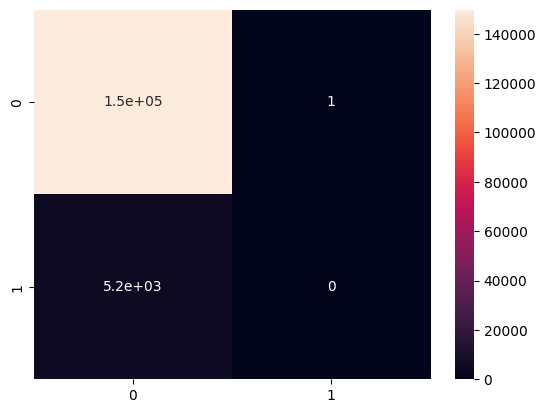

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true.detach().to('cpu'), preds)
sns.heatmap(cm, annot=True)